In [1]:
%matplotlib inline


# Spectral analysis with the High Level Interface

Introduction to 1D analysis using the Gammapy high level interface adapted
for the hands-on session.

## Prerequisites

-  Understanding the gammapy data workflow, in particular what are DL3
   events and instrument response functions (IRF).

## Context

This notebook is an introduction to gammapy analysis using the high
level interface.

Gammapy analysis consists in two main steps.

The first one is data reduction: user selected observations are reduced
to a geometry defined by the user. It can be 1D (spectrum from a given
extraction region) or 3D (with a sky projection and an energy axis). The
resulting reduced data and instrument response functions (IRF) are
called datasets in Gammapy.

The second step consists in setting a physical model on the datasets and
fitting it to obtain relevant physical information.

**Objective: Create a 1D dataset of the Crab using the H.E.S.S. DL3 data
release 1 and perform a simple model fitting of the Crab nebula.**


![gpy_data_flow](images/data-flow-gammapy.png)

## Proposed approach

This notebook uses the high level `~gammapy.analysis.Analysis` class to orchestrate data
reduction and run the data fits. In its current state, `Analysis`
supports the standard analysis cases of joint or stacked 3D and 1D
analyses. It is instantiated with an `~gammapy.analysis.AnalysisConfig` object that
gives access to analysis parameters either directly or via a YAML config
file.

To see what is happening under-the-hood and to get an idea of the
internal API, a second notebook performs the same analysis without using
the `~gammapy.analysis.Analysis` class.

In summary, we have to:

-  Create an `~gammapy.analysis.AnalysisConfig` object and the
   analysis configuration:

   -  Define what observations to use
   -  Define the geometry of the dataset (data and IRFs)
   -  Define the model we want to fit on the dataset.

-  Instantiate a `~gammapy.analysis.Analysis` from this configuration
   and run the different analysis steps

   -  Observation selection
   -  Data reduction
   -  Model fitting
   -  Estimating flux points


In [2]:
from pathlib import Path

# %matplotlib inline
import matplotlib.pyplot as plt

## Setup




In [3]:
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import Models

## Check setup



In [4]:
from gammapy.utils.check import check_tutorials_setup

# check_tutorials_setup()

## Analysis configuration

For configuration of the analysis we use the
[YAML](https://en.wikipedia.org/wiki/YAML)_ data format. YAML is a
machine readable serialisation format, that is also friendly for humans
to read. In this tutorial we will write the configuration file just
using Python strings, but of course the file can be created and modified
with any text editor of your choice.

Here is what the configuration for our analysis looks like:




In [5]:
yaml_str = """
observations:
    datastore: hess-dl3-dr1
    obs_cone: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 5 deg}

datasets:
    type: 1d
    stack: true
    geom:
        axes:
            energy: {min: 0.5 TeV, max: 30 TeV, nbins: 20}
            energy_true: {min: 0.1 TeV, max: 50 TeV, nbins: 40}
    on_region: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 0.11 deg}
    containment_correction: true
    background:
        method: reflected
fit:
    fit_range: {min: 1 TeV, max: 20 TeV}

flux_points:
    energy: {min: 1 TeV, max: 20 TeV, nbins: 8}
    source: 'crab'
"""

config = AnalysisConfig.from_yaml(yaml_str)
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 5.0 deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.5 TeV, max: 30.0 TeV, nbins: 20}
                energy_true: {min: 0.1 TeV, max: 50.0 TeV, nbins: 40}
        map_selection: [counts, exposure, background, psf, 

### Using data stored into your computer




Here, we want to use Crab runs from the H.E.S.S. DL3-DR1. We have
defined the datastore and a cone search of observations pointing with 5
degrees of the Crab nebula. Parameters can be set directly or as a
python dict.

### Setting the exclusion mask




In order to properly adjust the background normalisation on regions
without gamma-ray signal, one needs to define an exclusion mask for the
background normalisation. We want to avoid any contamination of signal
in the OFF regions.

The background is estimated using as many OFF regions as possible in a ring with a radius equal to the
offset between the pointing of the telescope and the source of interest. For example,

![off_regions](images/off_regions.png)


For this tutorial, we use the following one
`$GAMMAPY_DATA/joint-crab/exclusion/exclusion_mask_crab.fits.gz`


In [6]:
config.datasets.background.exclusion = (
    "joint-crab/exclusion/exclusion_mask_crab.fits.gz"
)

This is the exclusion mask defined in the exclusion_mask_crab.fits.gz file

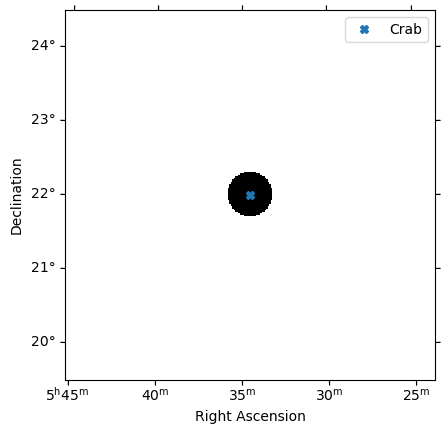

In [7]:
from astropy.io import fits
from gammapy.maps import Map

with fits.open("joint-crab/exclusion/exclusion_mask_crab.fits.gz") as hdul:    
    exclusion_map=Map.from_hdulist(hdul)
    
exclusion_map.plot()

from astropy.coordinates import SkyCoord
Crab_pos=SkyCoord.from_name("Crab Nebula")

plt.plot(Crab_pos.to_pixel(exclusion_map.geom.wcs)[0],
         Crab_pos.to_pixel(exclusion_map.geom.wcs)[1],
         "X",label="Crab")
plt.legend();

## Running the first step of the analysis: the Data Reduction




### Configuration of the analysis

We first create an `~gammapy.analysis.Analysis` object from our
configuration.




In [8]:
analysis = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


### Observation selection

We can directly select and load the observations from disk using
`~gammapy.analysis.Analysis.get_observations()`:




In [9]:
analysis.get_observations()

Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4


The observations are now available on the `Analysis` object. The
selection corresponds to the following ids:




In [10]:
print(analysis.observations.ids)

['23523', '23526', '23559', '23592']


To see how to explore observations, please refer to the following
notebook: :doc:`/tutorials/data/cta` or :doc:`/tutorials/data/hess`




### Running the Data Reduction and binning

Now we proceed to the data reduction and binning of the data. 
In the config file we have chosen to do a 1D analysis, an energy axis and decided to stack the maps. We can
run the reduction using `.get_datasets()`:

Since we specified a 1D analysis, the data is not binned in spatial coordinates, only in energy!


In [11]:
analysis.get_datasets()

Reducing spectrum datasets.
Creating the background Maker.


### Results exploration

As we have chosen to stack the data, one can print what contains the
unique entry of the datasets:




In [12]:
print(analysis.datasets[0])

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 427 
  Total background counts         : 25.86
  Total excess counts             : 401.14

  Predicted counts                : 43.14
  Predicted background counts     : 43.14
  Predicted excess counts         : nan

  Exposure min                    : 2.90e+07 m2 s
  Exposure max                    : 2.64e+09 m2 s

  Number of total bins            : 20 
  Number of fit bins              : 18 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1396.10

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 581 
  Acceptance                      : 20 
  Acceptance off                  : 495 



As you can see the dataset uses WStat (the mean signal of the background is considered as a nuisance parameter in the likelihood) with the estimation of the background using the Reflected Background method during the data reduction, but no source model has been set yet.

The counts, exposure and background, etc are directly available on the
dataset and can be printed:




In [13]:
info_table = analysis.datasets.info_table()
info_table

print(
    f"Tobs={info_table['livetime'].to('h')[0]:.1f} Excess={info_table['excess'].value[0]:.1f} \
Significance={info_table['sqrt_ts'][0]:.2f}"
)

Tobs=1.8 h Excess=401.1 Significance=37.04


## Model fitting




### Creation of the model

First, let’s create a model to be adjusted. As we are performing a 1D
Analysis, only a spectral model is needed within the `SkyModel`
object. Here is a pre-defined YAML configuration file created for this
1D analysis:




In [14]:
model_str = """
components:
- name: crab
  type: SkyModel
  spectral:
    type: PowerLawSpectralModel
    parameters:
      - name: index
        frozen: false
        scale: 1.0
        unit: ''
        value: 2.6
      - name: amplitude
        frozen: false
        scale: 1.0
        unit: cm-2 s-1 TeV-1
        value: 5.0e-11
      - name: reference
        frozen: true
        scale: 1.0
        unit: TeV
        value: 1.0
"""
model_1d = Models.from_yaml(model_str)
print(model_1d)

Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.600   +/-    0.00             
    amplitude                     :   5.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         




Now we set the model on the analysis object:




In [15]:
analysis.set_models(model_1d)

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.600   +/-    0.00             
    amplitude                     :   5.00e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         




### Setting fitting parameters

`Analysis` can perform a few modeling and fitting tasks besides data
reduction. Parameters have then to be passed to the configuration
object.




### Running the fit




In [16]:
analysis.run_fit()

Fitting datasets.
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 37
	total stat : 10.29

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



### Exploration of the fit results




In [17]:
print(analysis.fit_result)

display(model_1d.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 37
	total stat : 10.29

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab,spectral,index,2.6768e+00,,1.035e-01,nan,nan,False,False,
crab,spectral,amplitude,4.6795e-11,cm-2 s-1 TeV-1,4.679e-12,nan,nan,False,True,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


To check the fit is correct, we compute the excess spectrum with the
predicted counts.




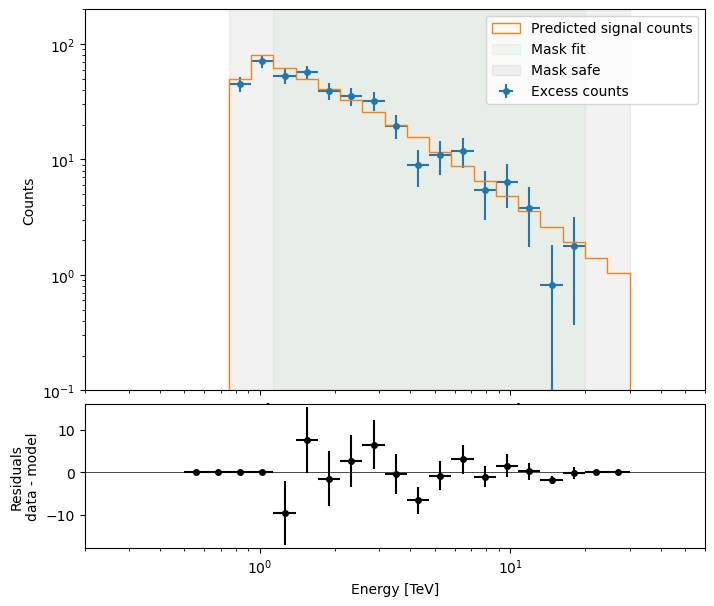

In [18]:
ax_spectrum, ax_residuals = analysis.datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 200)
ax_spectrum.set_xlim(0.2, 60)
ax_residuals.set_xlim(0.2, 60)
ax_spectrum.set_ylabel("Counts")
analysis.datasets[0].plot_masks(ax=ax_spectrum);

## Creation of the Flux points




### Running the estimation




In [19]:
analysis.get_flux_points()

crab_fp = analysis.flux_points.data
crab_fp_table = crab_fp.to_table(sed_type="dnde", formatted=True)
display(crab_fp_table)

Calculating flux points.
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend

      e_ref                 dnde          ...      sqrt_ts      
       TeV            1 / (cm2 s TeV)     ...                   
------------------ ---------------------- ... ------------------
1.1339665776330272  2.83464

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
1.134,0.924,1.392,2.835e-11,4.025e-12,4.206e-12,3.848e-12,3.713e-11,186.317,13.650,55.99956565687912,52.7632,0.000,False,56.0,True,0.200 .. 5.000,61.061 .. 323.310
1.708,1.392,2.096,1.193e-11,1.255e-12,1.297e-12,1.215e-12,1.461e-11,332.322,18.230,102.04656908663597,96.13059,0.718,False,102.0,True,0.200 .. 5.000,137.686 .. 402.694
2.572,2.096,3.156,4.325e-12,5.410e-13,5.626e-13,5.199e-13,5.494e-12,245.483,15.668,70.98310585226739,67.42658,0.329,False,71.0,True,0.200 .. 5.000,105.216 .. 245.371
3.873,3.156,4.753,1.002e-12,1.965e-13,2.084e-13,1.850e-13,1.443e-12,82.752,9.097,30.96858887289666,28.465975,1.663,False,31.0,True,0.200 .. 5.000,30.617 .. 190.044
5.833,4.753,7.158,4.655e-13,1.001e-13,1.070e-13,9.338e-14,6.937e-13,88.590,9.412,24.13312013593272,22.806488,0.725,False,24.0,True,0.200 .. 5.000,35.669 .. 89.296
7.929,7.158,8.784,1.527e-13,6.872e-14,7.833e-14,5.976e-14,3.297e-13,15.993,3.999,5.999944827284139,5.452217,0.000,False,6.0,True,0.200 .. 5.000,5.680 .. 33.974
10.779,8.784,13.228,9.692e-14,3.167e-14,3.499e-14,2.864e-14,1.739e-13,33.004,5.745,10.956513049909981,10.141874,0.117,False,11.0,True,0.200 .. 5.000,15.247 .. 34.090
16.233,13.228,19.921,1.523e-14,1.034e-14,1.239e-14,8.463e-15,4.443e-14,6.003,2.450,2.954099038455318,2.5607193,0.608,False,3.0,True,0.200 .. 5.000,2.084 .. 28.509


Let’s plot the flux points with their likelihood profile




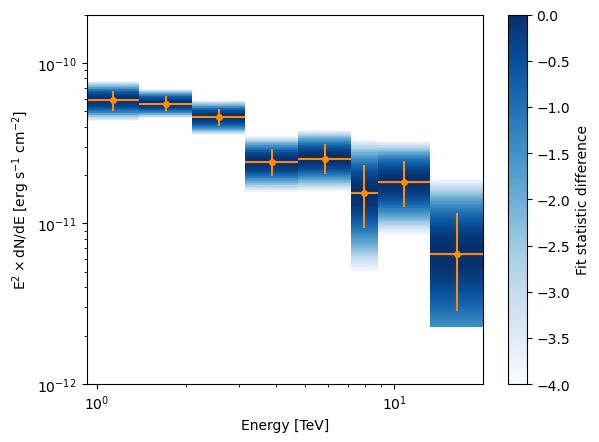

In [20]:
fig, ax_sed = plt.subplots()
crab_fp.plot(ax=ax_sed, sed_type="e2dnde", color="darkorange")
ax_sed.set_ylim(1.0e-12, 2.0e-10)
ax_sed.set_xlim(0.5, 40)
crab_fp.plot_ts_profiles(ax=ax_sed, sed_type="e2dnde")
ax_sed.set_ylabel(fr"E$^2 \times$dN/dE [erg s$^{{-1}}$ cm$^{{-2}}$]");

## Plotting the final results of the 1D Analysis




We can plot of the spectral fit with its error band overlaid with the
flux points:




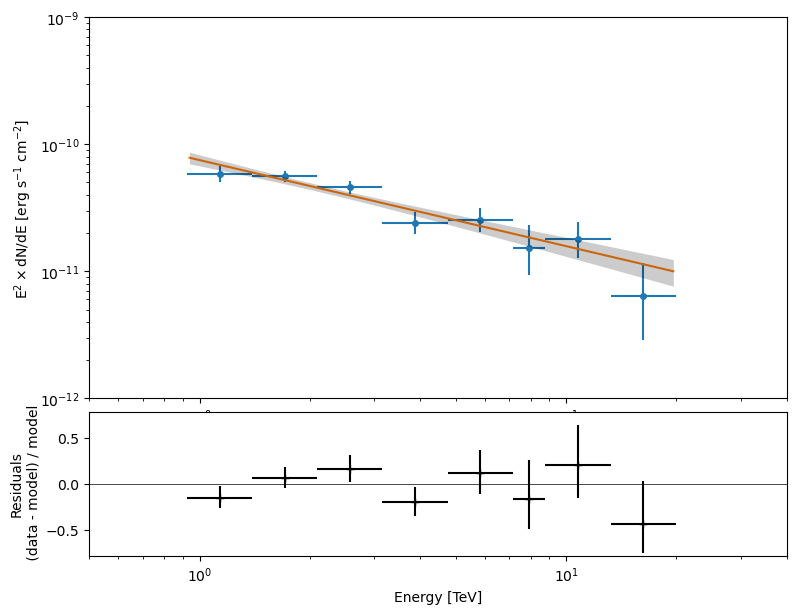

In [21]:
ax_sed, ax_residuals = analysis.flux_points.plot_fit()
ax_sed.set_ylim(1.0e-12, 1.0e-9)
ax_sed.set_xlim(0.5, 40)
ax_sed.set_ylabel(fr"E$^2 \times$dN/dE [erg s$^{{-1}}$ cm$^{{-2}}$]")
plt.show()

## What’s next?

Do the 3D analysis of the Crab data!


